In [1]:
#import os
#import sys

# 從/notebooks回到根目錄
#sys.path.append(os.path.abspath(".."))  # 指向根目錄 /PycharmProjects/MMAT
#from config.load_env import load_keys

#keys = load_keys()
#print("Loaded keys:", keys)

In [2]:
from binance.client import Client

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data(csv_path):

    df = pd.read_csv(csv_path, index_col='timestamp', parse_dates=True)
    df = df[['open', 'high', 'low', 'close', 'volume']].copy()
    print(f"Total K-lines loaded: {len(df)}")  # count total k lines
    print("First 5 rows:")
    print(df.head())
    return df

In [4]:
import talib

def calculate_patterns(df):

    patterns = {
        'Engulfing': talib.CDLENGULFING,  # Engulfing, detects bullish/bearish reversal
        'Hammer': talib.CDLHAMMER,  # Hammer, indicates potential reversal
        'InvertedHammer': talib.CDLINVERTEDHAMMER,  # Inverted Hammer, indicates potential reversal
        'ShootingStar': talib.CDLSHOOTINGSTAR,  # Shooting Star, indicates potential reversal
        'MorningStar': talib.CDLMORNINGSTAR,  # Morning Star, bullish reversal signal
        'EveningStar': talib.CDLEVENINGSTAR,  # Evening Star, bearish reversal signal
        'ThreeWhiteSoldiers': talib.CDL3WHITESOLDIERS  # Three White Soldiers pattern, confirms bullish trend
    }
    for name, func in patterns.items():
        df[name] = func(df['open'], df['high'], df['low'], df['close'])  # Calculate each pattern, values are 100(bullish) /-100 (bearish) /0 (no pattern)

    # Simple validation for abnormal Engulfing frequency
    engulfing_count = df['Engulfing'].abs().sum()
    if engulfing_count > len(df) * 0.1:  # Assume more than 10% may indicate an anomaly
        print(f"Warning: Engulfing detected {engulfing_count} times, which may indicate data or interval issues.")
    return df, patterns



In [5]:
def generate_signals(df, patterns, window=1):
    """
    根據K線形態生成買賣信號。
    參數:
        patterns (dict): 形態與函數的映射。
        window (int): 預測的未來時間窗口（預設為1分鐘），表示下一根K線的預測。
    自定義邏輯:
        - 形態值 > 0 時生成買入信號 (1)。
        - 形態值 < 0 時生成賣出信號 (-1)。
        - 否則為0（無信號）。
        - 'return' 計算下一根K線的收益率，'direction' 用於分類UP/DOWN/SLIGHT。
    返回:
        df (pd.DataFrame): 添加了信號列的數據框。
    """
    for name in patterns.keys():
        df[f'Signal_{name}'] = 0
    df['next_close'] = df['close'].shift(-window)  # 下一根K線的收盤價
    df['return'] = (df['next_close'] - df['close']) / df['close']  # 收益率
    threshold = 0.001  # 參數：收益率閾值，用於區分UP/DOWN price movement based on the calculated return
    df['direction'] = df['return'].apply(lambda x: 'UP' if x >= threshold else 'DOWN' if x <= -threshold else 'SLIGHT')

    for i in range(1, len(df)-window):
        for name in patterns.keys():
            if name in df.columns and df[name].iloc[i] > 0:
                df.at[df.index[i], f'Signal_{name}'] = 1  # Buy signal
                df.at[df.index[i], f'Direction_{name}'] = 'UP'  # Expect price to go up (bullish reversal)
            elif name in df.columns and df[name].iloc[i] < 0:
                df.at[df.index[i], f'Signal_{name}'] = -1  # Sell signal
                df.at[df.index[i], f'Direction_{name}'] = 'DOWN'  # Expect price to go down (bearish reversal)
    return df

In [6]:
#generate_signals(data, patterns)

In [7]:
def backtest_signals(df, signal_col, hold_period=5):
    if signal_col not in df.columns:
        raise ValueError(f"信號欄位 '{signal_col}' 不存在。可用欄位：{df.columns}")
    initial_cash = 10000
    position = 0
    cash = initial_cash
    signal_count = 0
    balance_history = [initial_cash]
    hold_counter = 0
    for i in range(1, len(df)):
        signal = df[signal_col].iloc[i]
        price = df['close'].iloc[i]
        if signal == 1 and position == 0:  # 買入
            position = cash / price
            cash = 0
            signal_count += 1
            hold_counter = hold_period
        elif signal == -1 and position == 0:  # 賣空
            position = -cash / price
            cash = cash + (cash / price * price)
            signal_count += 1
            hold_counter = hold_period
        elif signal == 1 and position < 0:  # 回補賣空
            cash = cash + (position * price)
            position = 0
            signal_count += 1
            hold_counter = 0
        elif signal == -1 and position > 0:  # 賣出多頭
            cash = position * price
            position = 0
            signal_count += 1
            hold_counter = 0
        elif position != 0 and hold_counter > 0:  # 持有部位
            hold_counter -= 1
            if hold_counter == 0:  # 自動賣出或回補
                cash = cash + (position * price)
                position = 0
                signal_count += 1
        current_balance = cash + (position * df['close'].iloc[i])
        balance_history.append(current_balance)
    final_balance = cash + (position * df['close'].iloc[-1])
    return final_balance, signal_count, balance_history

In [8]:
def plot_signals(df, symbol, patterns, results):
    """
    可視化資金餘額變化。
    參數:
        df (pd.DataFrame): 包含信號的數據框。
        symbol (str): 交易對名稱（如 'BTC'）。
        patterns (dict): 形態與函數的映射。
        results (dict): 包含每個策略的資金餘額、信號次數和資金歷史。

    """
    # 資金餘額變化折線圖
    for name in patterns.keys():
        plt.figure(figsize=(12, 6))
        balance_history = results[name]['balance_history']
        plt.plot(df.index[:len(balance_history)], balance_history, label=f'{name} Balance', color='blue')
        plt.title(f'Balance Over Time for {name} Strategy')
        plt.xlabel('Time')
        plt.ylabel('Balance ($)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Total K-lines loaded: 526000
First 5 rows:
                         open      high       low     close    volume
timestamp                                                            
2024-04-30 16:00:00  60796.86  60819.07  60713.22  60815.04  55.38665
2024-04-30 16:01:00  60815.04  60815.05  60688.80  60707.61  26.68472
2024-04-30 16:02:00  60707.61  60707.61  60616.04  60671.50  41.16678
2024-04-30 16:03:00  60671.51  60824.38  60649.01  60794.13  31.65158
2024-04-30 16:04:00  60794.12  60892.41  60793.97  60892.40  29.64754

--- Performance  ---
1. Hammer - Final Balance：$16431.88，Signal Count：39882
2. Engulfing - Final Balance：$15670.51，Signal Count：111234
3. ShootingStar - Final Balance：$11361.76，Signal Count：5624
4. ThreeWhiteSoldiers - Final Balance：$11346.65，Signal Count：7866
5. EveningStar - Final Balance：$10011.46，Signal Count：2484
6. MorningStar - Final Balance：$9695.07，Signal Count：2818
7. InvertedHammer - Final Balance：$8564.56，Signal Count：6854


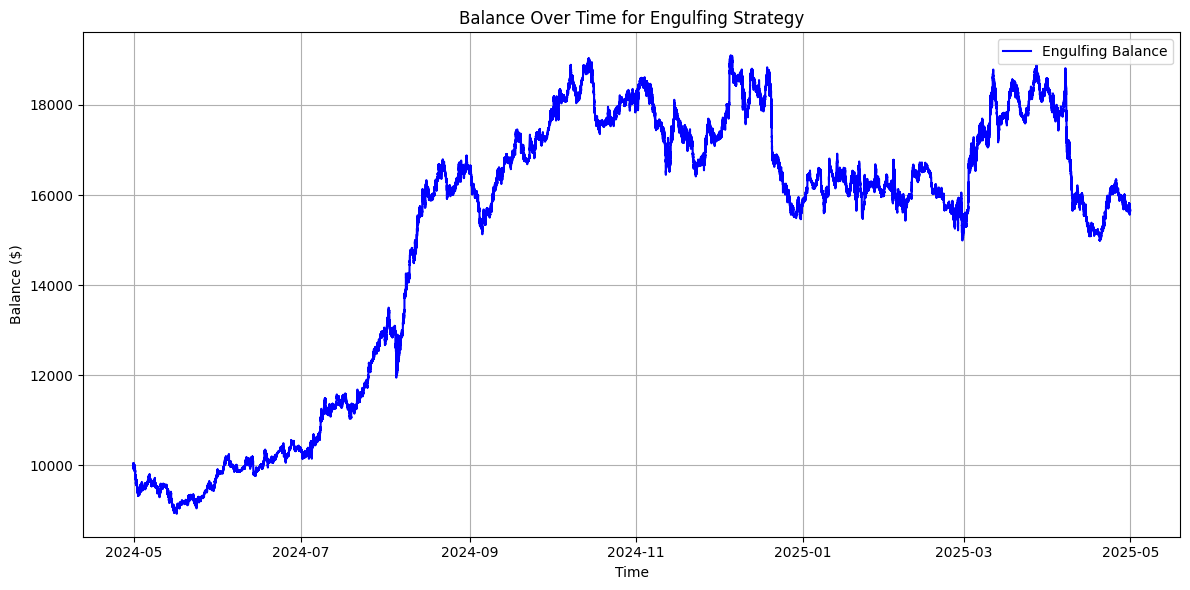

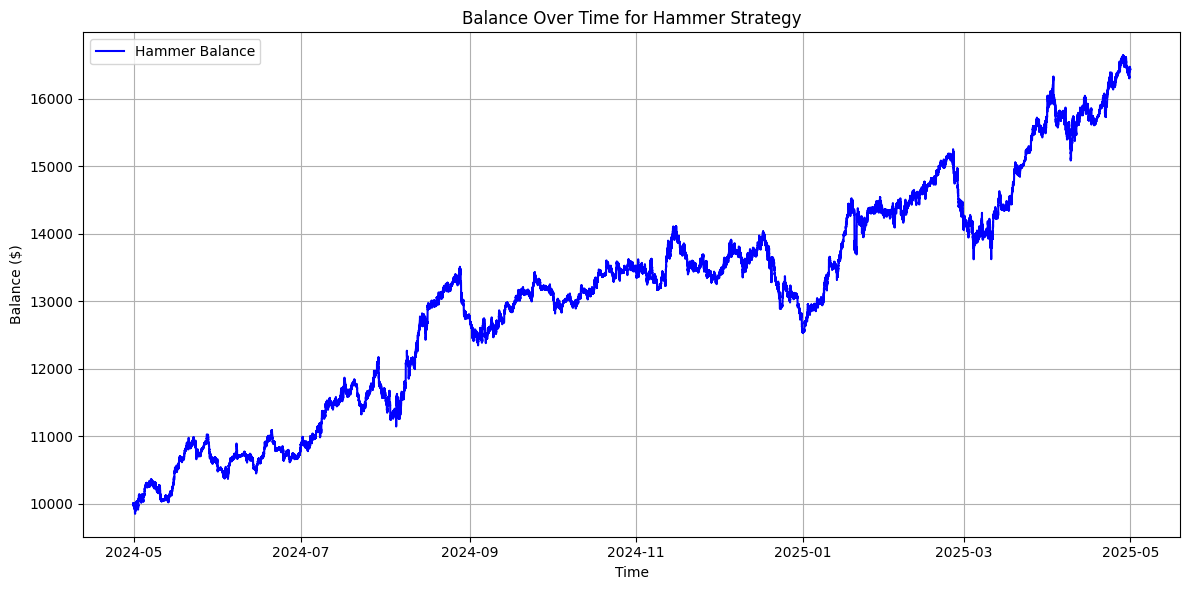

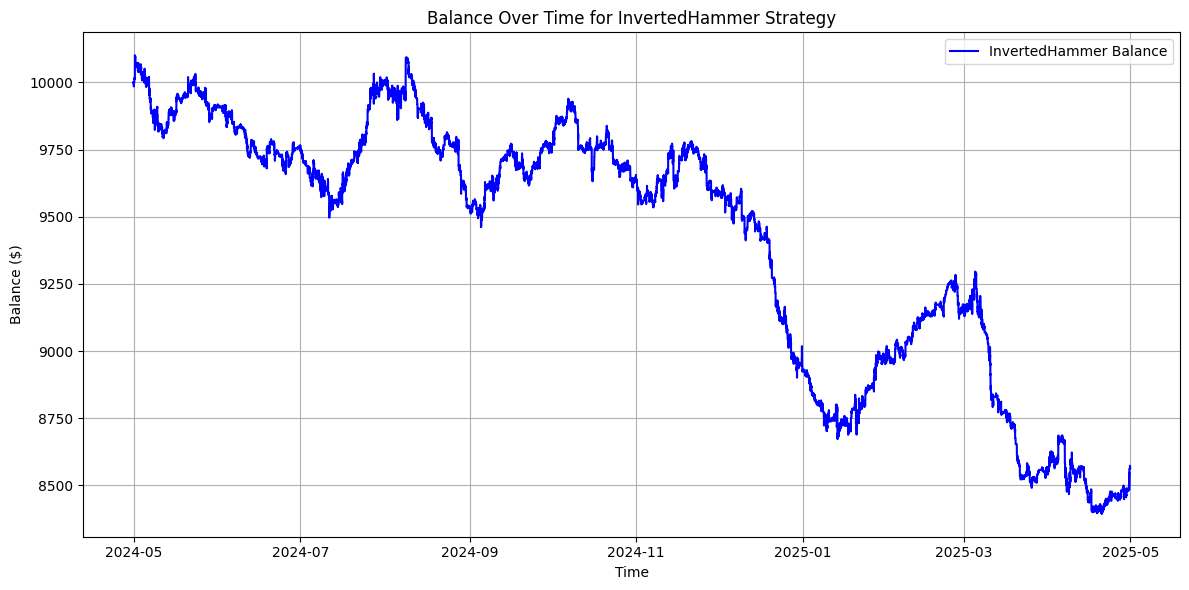

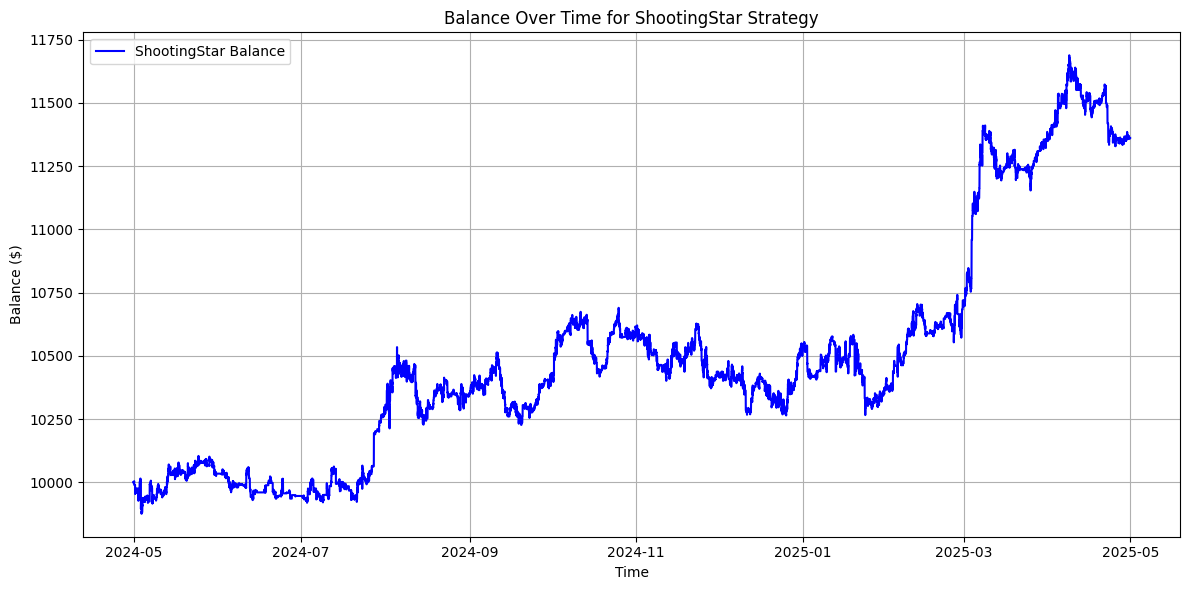

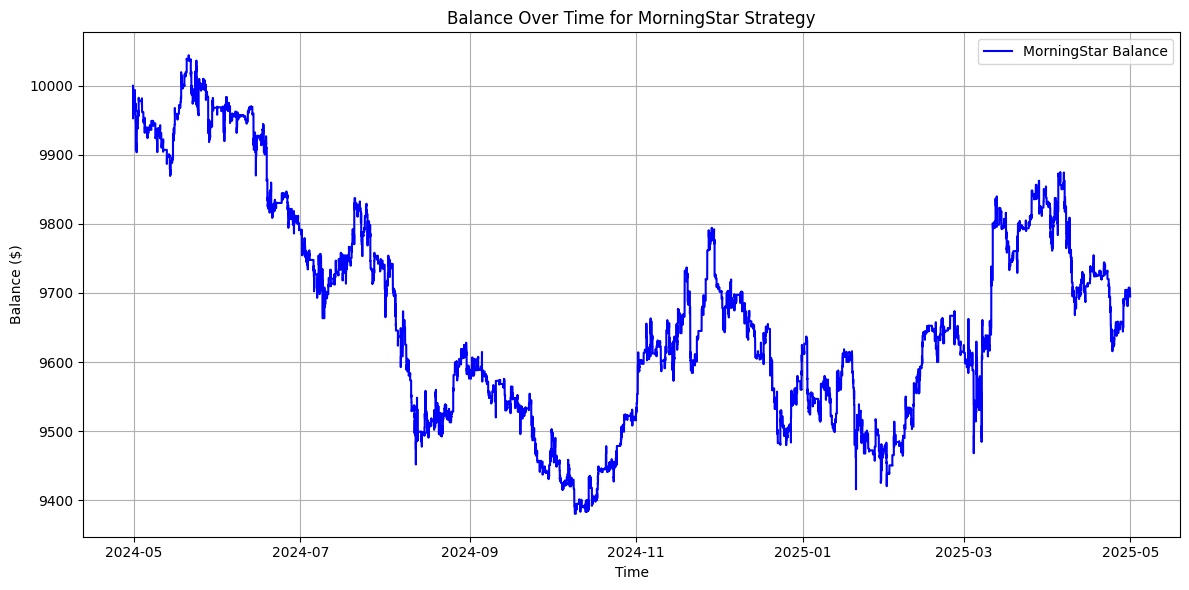

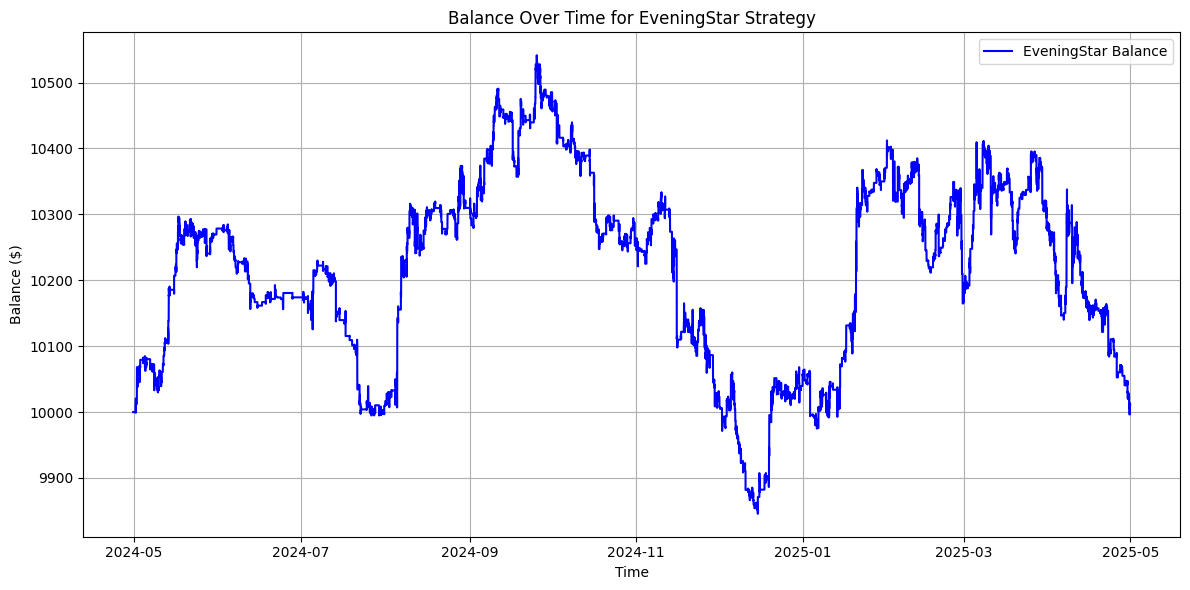

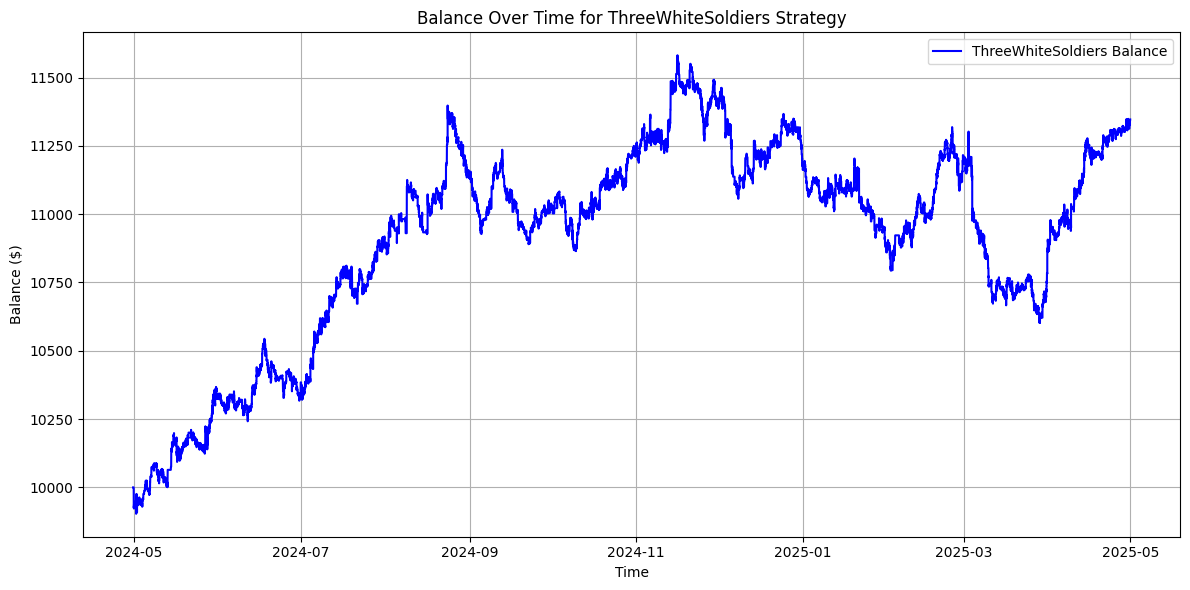

In [17]:
def main():
    csv_path = 'btc_1min.csv'
    df = load_data(csv_path)
    df, patterns = calculate_patterns(df)
    df = generate_signals(df, patterns, window=1)
    results = {}
    for name in patterns.keys():
        signal_col = f'Signal_{name}'
        balance, signal_count, balance_history = backtest_signals(df, signal_col, hold_period=5)
        total_return = ((balance - 10000) / 10000) * 100
        results[name] = {
            'balance': balance,
            'signal_count': signal_count,
            'balance_history': balance_history,
            'total_return': total_return
        }
    print("\n--- Performance  ---")
    performance = sorted(results.items(), key=lambda x: x[1]['balance'], reverse=True)
    for i, (name, metrics) in enumerate(performance, 1):
        print(f"{i}. {name} - Final Balance：${metrics['balance']:.2f}，Signal Count：{metrics['signal_count']}")
    plot_signals(df, 'BTC', patterns, results)
if __name__ == "__main__":
    main()

In [10]:
def summarize_directions(df, patterns):
    """
    Summarize the count of UP/DOWN/NONE directions for each pattern and visualize with matplotlib.
    """
    direction_summary = {}
    for name in patterns.keys():
        direction_counts = df[f'Direction_{name}'].value_counts()
        direction_summary[name] = direction_counts.to_dict()
        print(f"\nDirection counts for {name}:")
        print(direction_counts)

        # Create a bar chart for direction counts using matplotlib
        counts = df[f'Direction_{name}'].value_counts().reindex(['UP', 'DOWN', 'NONE'], fill_value=0)
        plt.figure(figsize=(6, 3))
        plt.bar(counts.index, counts.values, color=['#36A2EB', '#FF6384', '#E7E9ED'], edgecolor='black')
        plt.title(f'Direction Counts for {name} Pattern')
        plt.xlabel('Direction')
        plt.ylabel('Count')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    return direction_summary

Total K-lines loaded: 526000
First 5 rows:
                         open      high       low     close    volume
timestamp                                                            
2024-04-30 16:00:00  60796.86  60819.07  60713.22  60815.04  55.38665
2024-04-30 16:01:00  60815.04  60815.05  60688.80  60707.61  26.68472
2024-04-30 16:02:00  60707.61  60707.61  60616.04  60671.50  41.16678
2024-04-30 16:03:00  60671.51  60824.38  60649.01  60794.13  31.65158
2024-04-30 16:04:00  60794.12  60892.41  60793.97  60892.40  29.64754

Direction counts for Engulfing:
Direction_Engulfing
DOWN    48181
UP      45671
Name: count, dtype: int64


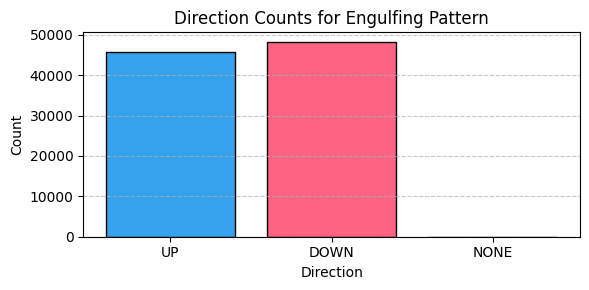


Direction counts for Hammer:
Direction_Hammer
UP    24677
Name: count, dtype: int64


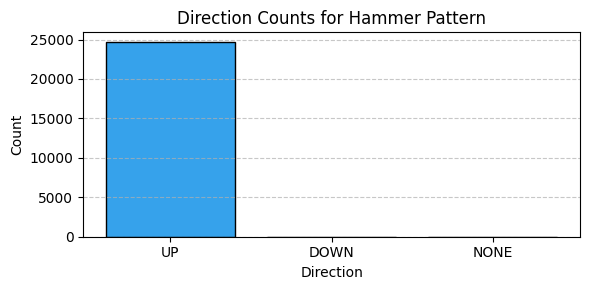


Direction counts for InvertedHammer:
Direction_InvertedHammer
UP    3550
Name: count, dtype: int64


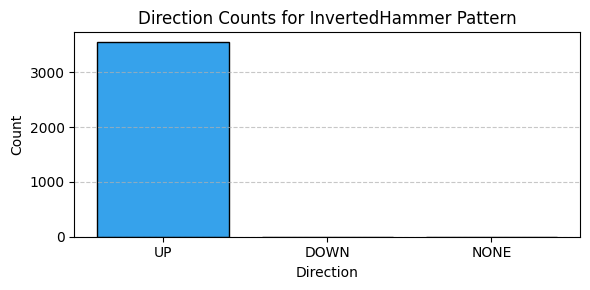


Direction counts for ShootingStar:
Direction_ShootingStar
DOWN    2912
Name: count, dtype: int64


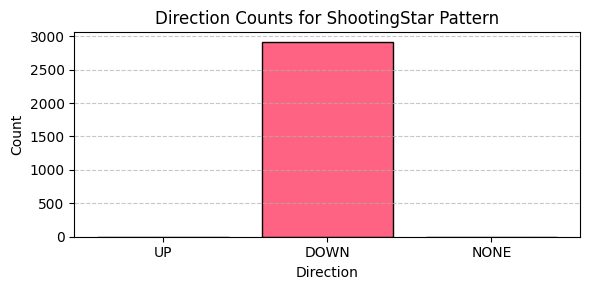


Direction counts for MorningStar:
Direction_MorningStar
UP    1418
Name: count, dtype: int64


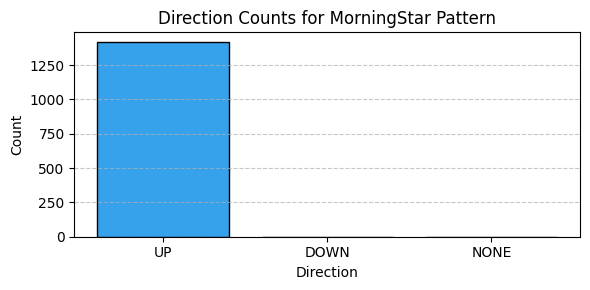


Direction counts for EveningStar:
Direction_EveningStar
DOWN    1253
Name: count, dtype: int64


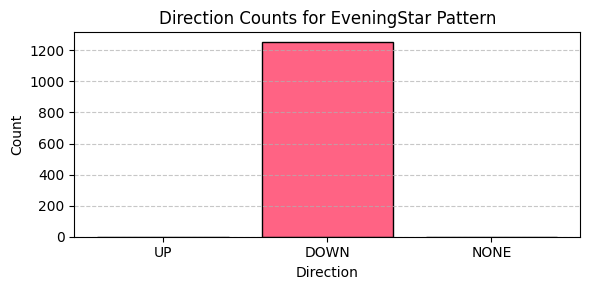


Direction counts for ThreeWhiteSoldiers:
Direction_ThreeWhiteSoldiers
UP    4589
Name: count, dtype: int64


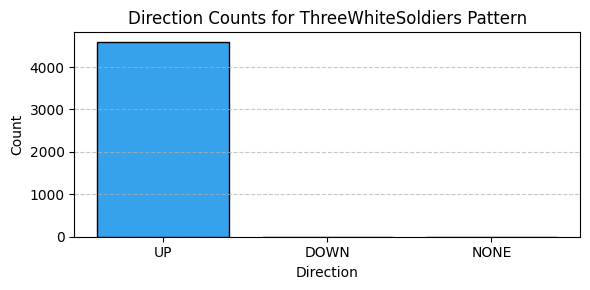

,open,high,low,close,volume,Engulfing,Hammer,InvertedHammer,ShootingStar,MorningStar,...,next_close,return,direction,Direction_Engulfing,Direction_MorningStar,Direction_Hammer,Direction_ThreeWhiteSoldiers,Direction_InvertedHammer,Direction_ShootingStar,Direction_EveningStar
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-04-30 16:00:00,60796.86,60819.07,60713.22,60815.04,55.38665,0,0,0,0,0,...,60707.61,-1.766504e-03,DOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-30 16:01:00,60815.04,60815.05,60688.80,60707.61,26.68472,0,0,0,0,0,...,60671.50,-5.948183e-04,SLIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-30 16:02:00,60707.61,60707.61,60616.04,60671.50,41.16678,0,0,0,0,0,...,60794.13,2.021213e-03,UP,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-30 16:03:00,60671.51,60824.38,60649.01,60794.13,31.65158,0,0,0,0,0,...,60892.40,1.616439e-03,UP,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-30 16:04:00,60794.12,60892.41,60793.97,60892.40,29.64754,0,0,0,0,0,...,60860.84,-5.182913e-04,SLIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30 22:35:00,94280.00,94311.75,94251.22,94265.38,12.98149,0,0,0,0,0,...,94284.62,2.041046e-04,SLIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-30 22:36:00,94265.39,94284.63,94264.52,94284.62,3.23475,0,0,0,0,0,...,94284.61,-1.060618e-07,SLIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-30 22:37:00,94284.62,94293.24,94277.72,94284.61,8.49435,0,0,0,0,0,...,94271.31,-1.410623e-04,SLIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Load data and generate signals
csv_path = 'btc_1min.csv'
df = load_data(csv_path)
df, patterns = calculate_patterns(df)
df = generate_signals(df, patterns, window=1)

# Summarize directions
summarize_directions(df, patterns)
generate_signals(df, patterns, window=1)